In [2]:
import json
import re
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import to_rgba
import seaborn as sns
import requests
from bs4 import BeautifulSoup
from pprint import pprint
import matplotlib.image as mpimg
import matplotlib.patches as patches
from io import BytesIO
import matplotlib as mpl
from matplotlib.gridspec import GridSpec
from matplotlib.markers import MarkerStyle
from mplsoccer import Pitch, VerticalPitch, FontManager, Sbopen, add_image
from matplotlib.font_manager import FontProperties
from matplotlib import rcParams
from matplotlib.patheffects import withStroke, Normal
from matplotlib.colors import LinearSegmentedColormap
from mplsoccer.utils import FontManager
import matplotlib.patheffects as path_effects
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from matplotlib.cbook import get_sample_data
from sklearn.cluster import KMeans
import warnings
from highlight_text import ax_text, fig_text
from PIL import Image
from urllib.request import urlopen
import os
import time
from unidecode import unidecode
from scipy.spatial import ConvexHull

#modify the dataframe
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)


#custom colors

green = '#69f900'
red = '#ff4b44'
blue = '#00a0de'
violet = '#a369ff'
bg_color= '#f5f5f5'
line_color= '#000000'
# bg_color= '#000000'
# line_color= '#ffffff'
col1 = '#ff4b44'
col2 = '#00a0de'



In [3]:
match_html_path = r"C:\Users\gerald wangai\Downloads\Liverpool 0-1 Nottingham Forest - Premier League 2024_2025 Live.html"
# Put the Fotmob matchId here
fotmob_matchId = 4506298

def extract_json_from_html(html_path, save_output=False):
    with open(html_path, 'r', encoding='utf-8') as html_file:
        html = html_file.read()

    regex_pattern = r'(?<=require\.config\.params\["args"\].=.)[\s\S]*?;'
    data_txt = re.findall(regex_pattern, html)[0]

    # add quotations for JSON parser
    data_txt = data_txt.replace('matchId', '"matchId"')
    data_txt = data_txt.replace('matchCentreData', '"matchCentreData"')
    data_txt = data_txt.replace('matchCentreEventTypeJson', '"matchCentreEventTypeJson"')
    data_txt = data_txt.replace('formationIdNameMappings', '"formationIdNameMappings"')
    data_txt = data_txt.replace('};', '}')

    if save_output:
        # save JSON data to txt
        output_file = open(f"{html_path}.txt", "wt", encoding='utf-8')
        n = output_file.write(data_txt)
        output_file.close()

    return data_txt

def filter_json_data(data):
    # load data from json
    event_types_json = data["matchCentreEventTypeJson"]
    formation_mappings = data["formationIdNameMappings"]
    events_data = data["matchCentreData"]["events"]
    teams_data = {data["matchCentreData"]['home']['teamId']: data["matchCentreData"]['home']['name'],
                  data["matchCentreData"]['away']['teamId']: data["matchCentreData"]['away']['name']}
    players_data = data["matchCentreData"]["playerIdNameDictionary"]
    # create players dataframe
    players_home_df = pd.DataFrame(data["matchCentreData"]['home']['players'])
    players_home_df["teamId"] = data["matchCentreData"]['home']['teamId']
    players_away_df = pd.DataFrame(data["matchCentreData"]['away']['players'])
    players_away_df["teamId"] = data["matchCentreData"]['away']['teamId']
    players_df = pd.concat([players_home_df, players_away_df])
    players_ids = data["matchCentreData"]["playerIdNameDictionary"]
    return events_data, players_df, teams_data


json_data_txt = extract_json_from_html(match_html_path)
data = json.loads(json_data_txt)
events_data, players_df, teams_data = filter_json_data(data)

df = pd.DataFrame(events_data)
dfp = pd.DataFrame(players_df)


#create csv files

df.to_csv("E:\important\Coding\Python Coding\Football Analytics/event_data.csv")
dfp.to_csv("E:\important\Coding\Python Coding\Football Analytics/player_data.csv")

df=pd.read_csv("E:\important\Coding\Python Coding\Football Analytics/event_data.csv")

dfp=pd.read_csv("E:\important\Coding\Python Coding\Football Analytics/player_data.csv")


# Extract the 'displayName' value
df['type'] = df['type'].str.extract(r"'displayName': '([^']+)")
df['outcomeType'] = df['outcomeType'].str.extract(r"'displayName': '([^']+)")
df['period'] = df['period'].str.extract(r"'displayName': '([^']+)")
df['qualifiers'] = df['qualifiers'].str.extract(r"'displayName': '([^']+)")



In [4]:
df.head()

,Unnamed: 0,id,eventId,minute,second,teamId,x,y,expandedMinute,period,type,outcomeType,qualifiers,satisfiedEventsTypes,isTouch,playerId,endX,endY,relatedEventId,relatedPlayerId,goalMouthZ,goalMouthY,isShot,blockedX,blockedY,cardType,isGoal
0,0,2.719864e+09,3,0,0.0,174,0.0,0.0,0,FirstHalf,Start,Successful,NaN,[],False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,2.719864e+09,3,0,0.0,26,0.0,0.0,0,FirstHalf,Start,Successful,NaN,[],False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,2.719864e+09,4,0,0.0,174,49.8,50.2,0,FirstHalf,Pass,Successful,Angle,"[91, 117, 30, 35, 38, 215, 218]",True,402596.0,25.0,49.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,2.719864e+09,5,0,3.0,174,28.0,40.0,0,FirstHalf,Pass,Successful,StandingSave,"[91, 119, 117, 127, 205, 36, 38, 217, 218]",True,78386.0,77.1,5.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,2.719864e+09,7,0,7.0,174,78.8,5.5,0,FirstHalf,Pass,Unsuccessful,PassEndY,"[91, 120, 29, 139, 36, 37, 217, 218]",True,73380.0,82.0,18.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
df.columns

Index(['Unnamed: 0', 'id', 'eventId', 'minute', 'second', 'teamId', 'x', 'y',
       'expandedMinute', 'period', 'type', 'outcomeType', 'qualifiers',
       'satisfiedEventsTypes', 'isTouch', 'playerId', 'endX', 'endY',
       'relatedEventId', 'relatedPlayerId', 'goalMouthZ', 'goalMouthY',
       'isShot', 'blockedX', 'blockedY', 'cardType', 'isGoal'],
      dtype='object')

In [6]:
df_type=df['type']

In [7]:
df_type.unique()

array(['Start', 'Pass', 'Aerial', 'Foul', 'Dispossessed', 'Tackle',
       'TakeOn', 'CornerAwarded', 'BallTouch', 'KeeperPickup',
       'BallRecovery', 'Clearance', 'BlockedPass', 'Challenge',
       'Interception', 'OffsideGiven', 'OffsidePass', 'OffsideProvoked',
       'Error', 'ShotOnPost', 'MissedShots', 'SavedShot', 'Save',
       'ShieldBallOpp', 'Claim', 'KeeperSweeper', 'Card', 'End',
       'SubstitutionOff', 'SubstitutionOn', 'FormationChange', 'Goal',
       'Punch', 'FormationSet'], dtype=object)

In [8]:
df_id=df['id']

In [9]:
df_id.unique()

array([2.71986405e+09, 2.71986407e+09, 2.71986415e+09, ...,
       2.72009660e+09, 2.71980316e+09, 2.71980320e+09])

In [10]:
df_nottingham=df[df['teamId']==174]

In [11]:
df_nottingham.head()

,Unnamed: 0,id,eventId,minute,second,teamId,x,y,expandedMinute,period,type,outcomeType,qualifiers,satisfiedEventsTypes,isTouch,playerId,endX,endY,relatedEventId,relatedPlayerId,goalMouthZ,goalMouthY,isShot,blockedX,blockedY,cardType,isGoal
0,0,2.719864e+09,3,0,0.0,174,0.0,0.0,0,FirstHalf,Start,Successful,NaN,[],False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,2.719864e+09,4,0,0.0,174,49.8,50.2,0,FirstHalf,Pass,Successful,Angle,"[91, 117, 30, 35, 38, 215, 218]",True,402596.0,25.0,49.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,2.719864e+09,5,0,3.0,174,28.0,40.0,0,FirstHalf,Pass,Successful,StandingSave,"[91, 119, 117, 127, 205, 36, 38, 217, 218]",True,78386.0,77.1,5.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,2.719864e+09,7,0,7.0,174,78.8,5.5,0,FirstHalf,Pass,Unsuccessful,PassEndY,"[91, 120, 29, 139, 36, 37, 217, 218]",True,73380.0,82.0,18.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,6,2.719864e+09,8,0,12.0,174,45.2,26.1,0,FirstHalf,Pass,Successful,Length,"[91, 119, 117, 30, 139, 36, 38, 216, 218]",True,445424.0,54.7,8.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
Nottingham_pass_events=df_nottingham[df_nottingham['type']=='Pass']

In [13]:
Nottingham_pass_events.head()

,Unnamed: 0,id,eventId,minute,second,teamId,x,y,expandedMinute,period,type,outcomeType,qualifiers,satisfiedEventsTypes,isTouch,playerId,endX,endY,relatedEventId,relatedPlayerId,goalMouthZ,goalMouthY,isShot,blockedX,blockedY,cardType,isGoal
2,2,2.719864e+09,4,0,0.0,174,49.8,50.2,0,FirstHalf,Pass,Successful,Angle,"[91, 117, 30, 35, 38, 215, 218]",True,402596.0,25.0,49.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,2.719864e+09,5,0,3.0,174,28.0,40.0,0,FirstHalf,Pass,Successful,StandingSave,"[91, 119, 117, 127, 205, 36, 38, 217, 218]",True,78386.0,77.1,5.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,2.719864e+09,7,0,7.0,174,78.8,5.5,0,FirstHalf,Pass,Unsuccessful,PassEndY,"[91, 120, 29, 139, 36, 37, 217, 218]",True,73380.0,82.0,18.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,6,2.719864e+09,8,0,12.0,174,45.2,26.1,0,FirstHalf,Pass,Successful,Length,"[91, 119, 117, 30, 139, 36, 38, 216, 218]",True,445424.0,54.7,8.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,7,2.719865e+09,9,0,13.0,174,54.7,10.4,0,FirstHalf,Pass,Successful,StandingSave,"[91, 119, 117, 127, 36, 37, 216, 218]",True,315543.0,65.3,13.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
Nottingham_pass_events=Nottingham_pass_events.loc[:, ~Nottingham_pass_events.columns.isin(['relatedEventId','relatedPlayerId','goalMouthZ','isShot','blockedX','blockedY','cardType','isGoal'])]

In [15]:
Nottingham_pass_events.head()

,Unnamed: 0,id,eventId,minute,second,teamId,x,y,expandedMinute,period,type,outcomeType,qualifiers,satisfiedEventsTypes,isTouch,playerId,endX,endY,goalMouthY
2,2,2.719864e+09,4,0,0.0,174,49.8,50.2,0,FirstHalf,Pass,Successful,Angle,"[91, 117, 30, 35, 38, 215, 218]",True,402596.0,25.0,49.1,NaN
3,3,2.719864e+09,5,0,3.0,174,28.0,40.0,0,FirstHalf,Pass,Successful,StandingSave,"[91, 119, 117, 127, 205, 36, 38, 217, 218]",True,78386.0,77.1,5.5,NaN
4,4,2.719864e+09,7,0,7.0,174,78.8,5.5,0,FirstHalf,Pass,Unsuccessful,PassEndY,"[91, 120, 29, 139, 36, 37, 217, 218]",True,73380.0,82.0,18.1,NaN
6,6,2.719864e+09,8,0,12.0,174,45.2,26.1,0,FirstHalf,Pass,Successful,Length,"[91, 119, 117, 30, 139, 36, 38, 216, 218]",True,445424.0,54.7,8.4,NaN
7,7,2.719865e+09,9,0,13.0,174,54.7,10.4,0,FirstHalf,Pass,Successful,StandingSave,"[91, 119, 117, 127, 36, 37, 216, 218]",True,315543.0,65.3,13.0,NaN


**Creating a Pass Map & Heat Map**

In [16]:
#change the team ID to Nottingham Forest
Nottingham_pass_events['teamId']=Nottingham_pass_events['teamId'].replace(174,'Nottingham Forest')





In [17]:
Nottingham_pass_events.head()

,Unnamed: 0,id,eventId,minute,second,teamId,x,y,expandedMinute,period,type,outcomeType,qualifiers,satisfiedEventsTypes,isTouch,playerId,endX,endY,goalMouthY
2,2,2.719864e+09,4,0,0.0,Nottingham Forest,49.8,50.2,0,FirstHalf,Pass,Successful,Angle,"[91, 117, 30, 35, 38, 215, 218]",True,402596.0,25.0,49.1,NaN
3,3,2.719864e+09,5,0,3.0,Nottingham Forest,28.0,40.0,0,FirstHalf,Pass,Successful,StandingSave,"[91, 119, 117, 127, 205, 36, 38, 217, 218]",True,78386.0,77.1,5.5,NaN
4,4,2.719864e+09,7,0,7.0,Nottingham Forest,78.8,5.5,0,FirstHalf,Pass,Unsuccessful,PassEndY,"[91, 120, 29, 139, 36, 37, 217, 218]",True,73380.0,82.0,18.1,NaN
6,6,2.719864e+09,8,0,12.0,Nottingham Forest,45.2,26.1,0,FirstHalf,Pass,Successful,Length,"[91, 119, 117, 30, 139, 36, 38, 216, 218]",True,445424.0,54.7,8.4,NaN
7,7,2.719865e+09,9,0,13.0,Nottingham Forest,54.7,10.4,0,FirstHalf,Pass,Successful,StandingSave,"[91, 119, 117, 127, 36, 37, 216, 218]",True,315543.0,65.3,13.0,NaN


In [18]:
#get the player id
#player_id=Nottingham_pass_events['playerId'].unique()

#get player name using the player_id
#def get_player_name(player_id):
    #url=f"https://www.whoscored.com/Players/{player_id}"
    #headers = {"User-Agent": "Mozilla/5.0"}
    #response=requests.get(url, headers=headers)
    #html_content=response.text
    #if response.status_code==200:
        #regex_pattern = r'(?<=require\.config\.params\["args"\].=.)[\s\S]*?;'
        #match = re.search(regex_pattern, html_content)
        
        
        #if match:
               # json_data = match.group().strip(";")  # Remove trailing semicolon
                
                #try:
                    #data = json.loads(json_data)  # Convert to dictionary
                    #return data.get("playerName", None)  # Extract player name
                #except json.JSONDecodeError:
                   # return None
    #return None            


#player_id_to_name={pid:get_player_name(pid) for pid in player_id }
#Nottingham_pass_events['playerId']=Nottingham_pass_events['playerId'].map(player_id_to_name)



In [19]:
Nottingham_pass_events.head()

,Unnamed: 0,id,eventId,minute,second,teamId,x,y,expandedMinute,period,type,outcomeType,qualifiers,satisfiedEventsTypes,isTouch,playerId,endX,endY,goalMouthY
2,2,2.719864e+09,4,0,0.0,Nottingham Forest,49.8,50.2,0,FirstHalf,Pass,Successful,Angle,"[91, 117, 30, 35, 38, 215, 218]",True,402596.0,25.0,49.1,NaN
3,3,2.719864e+09,5,0,3.0,Nottingham Forest,28.0,40.0,0,FirstHalf,Pass,Successful,StandingSave,"[91, 119, 117, 127, 205, 36, 38, 217, 218]",True,78386.0,77.1,5.5,NaN
4,4,2.719864e+09,7,0,7.0,Nottingham Forest,78.8,5.5,0,FirstHalf,Pass,Unsuccessful,PassEndY,"[91, 120, 29, 139, 36, 37, 217, 218]",True,73380.0,82.0,18.1,NaN
6,6,2.719864e+09,8,0,12.0,Nottingham Forest,45.2,26.1,0,FirstHalf,Pass,Successful,Length,"[91, 119, 117, 30, 139, 36, 38, 216, 218]",True,445424.0,54.7,8.4,NaN
7,7,2.719865e+09,9,0,13.0,Nottingham Forest,54.7,10.4,0,FirstHalf,Pass,Successful,StandingSave,"[91, 119, 117, 127, 36, 37, 216, 218]",True,315543.0,65.3,13.0,NaN


In [20]:
dfp.head()

,Unnamed: 0,playerId,shirtNo,name,position,height,weight,age,isFirstEleven,isManOfTheMatch,field,stats,subbedInPlayerId,subbedOutPeriod,subbedOutExpandedMinute,subbedInPeriod,subbedInExpandedMinute,subbedOutPlayerId,teamId
0,0,114147,1,Alisson Becker,GK,193,91,31,True,False,home,"{'totalSaves': {'59': 1.0, '88': 1.0}, 'parrie...",NaN,NaN,NaN,NaN,NaN,NaN,26
1,1,318871,66,Trent Alexander-Arnold,DR,175,67,25,True,False,home,"{'possession': {'6': 1.0, '7': 2.0, '9': 3.0, ...",NaN,NaN,NaN,NaN,NaN,NaN,26
2,2,345957,5,Ibrahima Konaté,DC,194,95,25,True,False,home,"{'possession': {'1': 1.0, '5': 2.0, '8': 1.0, ...",355354.0,"{'value': 2, 'displayName': 'SecondHalf'}",78.0,NaN,NaN,NaN,26
3,3,95408,4,Virgil van Dijk,DC,195,92,33,True,True,home,"{'possession': {'0': 2.0, '1': 1.0, '3': 1.0, ...",NaN,NaN,NaN,NaN,NaN,NaN,26
4,4,115726,26,Andy Robertson,DL,178,64,30,True,False,home,"{'possession': {'0': 1.0, '1': 1.0, '2': 1.0, ...",301455.0,"{'value': 2, 'displayName': 'SecondHalf'}",78.0,NaN,NaN,NaN,26


In [21]:
dfp=dfp[dfp['teamId']==174]

In [22]:



columns_to_drop=['position','teamId','height','weight','age','isFirstEleven','isManOfTheMatch','field','stats','subbedInPlayerId','subbedOutPeriod','subbedOutExpandedMinute','subbedInPeriod','subbedInExpandedMinute','subbedOutPlayerId']


dfp=dfp.drop(columns_to_drop, axis=1).head()




In [23]:
merged_df=pd.merge(Nottingham_pass_events,dfp , on='playerId')

In [24]:
merged_df.head()

,Unnamed: 0_x,id,eventId,minute,second,teamId,x,y,expandedMinute,period,type,outcomeType,qualifiers,satisfiedEventsTypes,isTouch,playerId,endX,endY,goalMouthY,Unnamed: 0_y,shirtNo,name
0,3,2.719864e+09,5,0,3.0,Nottingham Forest,28.0,40.0,0,FirstHalf,Pass,Successful,StandingSave,"[91, 119, 117, 127, 205, 36, 38, 217, 218]",True,78386.0,77.1,5.5,NaN,0,26,Matz Sels
1,6,2.719864e+09,8,0,12.0,Nottingham Forest,45.2,26.1,0,FirstHalf,Pass,Successful,Length,"[91, 119, 117, 30, 139, 36, 38, 216, 218]",True,445424.0,54.7,8.4,NaN,2,5,Murillo
2,7,2.719865e+09,9,0,13.0,Nottingham Forest,54.7,10.4,0,FirstHalf,Pass,Successful,StandingSave,"[91, 119, 117, 127, 36, 37, 216, 218]",True,315543.0,65.3,13.0,NaN,1,34,Ola Aina
3,36,2.719869e+09,21,2,22.0,Nottingham Forest,10.5,40.3,2,FirstHalf,Pass,Successful,PassEndX,"[91, 119, 117, 127, 36, 38, 216, 218]",True,78386.0,55.6,11.1,NaN,0,26,Matz Sels
4,49,2.719872e+09,29,4,3.0,Nottingham Forest,38.8,8.9,4,FirstHalf,Pass,Successful,Length,"[91, 119, 117, 30, 36, 37, 216, 218]",True,315543.0,57.6,10.2,NaN,1,34,Ola Aina


**CREATE PASS MAPS**

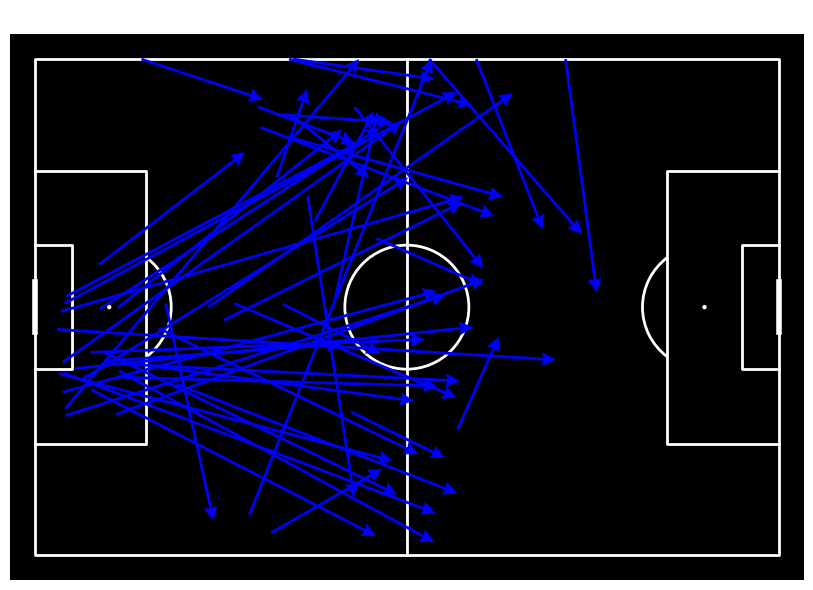

In [25]:
def calculate_progressive_passes(df, x_col='x', y_col='y', end_x_col='endX', end_y_col='endY', min_distance=15, left_to_right=True):
    # Calculate pass distance
    df['pass_distance'] = np.sqrt((df[end_x_col] - df[x_col]) ** 2 + (df[end_y_col] - df[y_col]) ** 2)
    
    # Determine progressive passes
    if left_to_right:
        df['is_progressive'] = (df['pass_distance'] > min_distance) & (df[end_x_col] > df[x_col])
    else:
        df['is_progressive'] = (df['pass_distance'] > min_distance) & (df[end_x_col] < df[x_col])

    # Remove passes outside the pitch boundaries (0, 0) to (120, 80)
    valid_passes = df[
        (df[x_col] >= 0) & (df[x_col] <= 120) &
        (df[y_col] >= 0) & (df[y_col] <= 80) &
        (df[end_x_col] >= 0) & (df[end_x_col] <= 120) &
        (df[end_y_col] >= 0) & (df[end_y_col] <= 80)
    ]

    return valid_passes[valid_passes['is_progressive']]



progressive_passes = calculate_progressive_passes(merged_df)

pitch = Pitch(pitch_type='statsbomb', pitch_color='black', line_color='white')
fig, ax = pitch.draw(figsize=(10, 6))

# Plot each progressive pass
pitch.arrows(progressive_passes['x'], progressive_passes['y'],
             progressive_passes['endX'], progressive_passes['endY'],
             color='blue', width=2, headwidth=5, headlength=5, ax=ax)

# Add title
ax.set_title('Progressive Passes Visualization', fontsize=16, color='white')

plt.show()


**PASS NETWORKS**

In [26]:
# Ensure the dataframe is sorted by minute and second
merged_df = merged_df.sort_values(['minute', 'second']).reset_index(drop=True)

# Shift the 'name' column to get the next player as the recipient
merged_df['pass_recipient'] = merged_df['name'].shift(-1)

# Optional: If the last pass does not have a recipient, fill it with NaN or 'Unknown'
merged_df['pass_recipient'].fillna('Unknown', inplace=True)




C:\Users\gerald wangai\AppData\Local\Temp\ipykernel_908\4277084082.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  merged_df['pass_recipient'].fillna('Unknown', inplace=True)


In [31]:
from mplsoccer import Pitch
import matplotlib.pyplot as plt

def create_pass_network(df, player_col='name', recipient_col='pass_recipient', x_col='x', y_col='y', min_passes=1):
    # Filter out rows where pass recipient is missing
    df = df[df[recipient_col].notna()]

    # Ensure coordinates are within StatsBomb pitch limits
    df[x_col] = df[x_col].clip(0, 120)
    df[y_col] = df[y_col].clip(0, 80)

    # Calculate average positions for each player
    player_positions = df.groupby(player_col).agg({x_col: 'mean', y_col: 'mean'}).reset_index()

    # Count the number of passes between players
    pass_counts = df.groupby([player_col, recipient_col]).size().reset_index(name='pass_count')

    # Filter out connections with fewer than min_passes
    pass_counts = pass_counts[pass_counts['pass_count'] >= min_passes]

    # Merge average positions for passing players
    pass_counts = pass_counts.merge(player_positions, left_on=player_col, right_on=player_col)
    pass_counts = pass_counts.merge(player_positions, left_on=recipient_col, right_on=player_col, suffixes=('', '_end'))

    # Create pitch and set figure size
    pitch = Pitch(pitch_type='statsbomb', pitch_color='black', line_color='white')
    fig, ax = plt.subplots(figsize=(10, 6))
    pitch.draw(ax=ax)

    # Plot player positions
    pitch.scatter(player_positions[x_col], player_positions[y_col], ax=ax, color='red', s=100, edgecolors='black', zorder=3)
    
    # Annotate player names
    for _, row in player_positions.iterrows():
        ax.text(row[x_col], row[y_col], row[player_col], fontsize=10, ha='center', va='center', color='white')

    # Plot pass connections within pitch boundaries
    for _, row in pass_counts.iterrows():
        start_x, start_y = row[x_col], row[y_col]
        end_x, end_y = row[x_col + '_end'], row[y_col + '_end']

        # Clip to ensure lines fit within pitch
        start_x, start_y = max(0, min(start_x, 120)), max(0, min(start_y, 80))
        end_x, end_y = max(0, min(end_x, 120)), max(0, min(end_y, 80))

        pitch.lines(start_x, start_y, end_x, end_y,
                    lw=row['pass_count'] / 2, color='blue', ax=ax, zorder=2)

    ax.set_title('Pass Network Visualization', fontsize=16, color='white')
    plt.show()


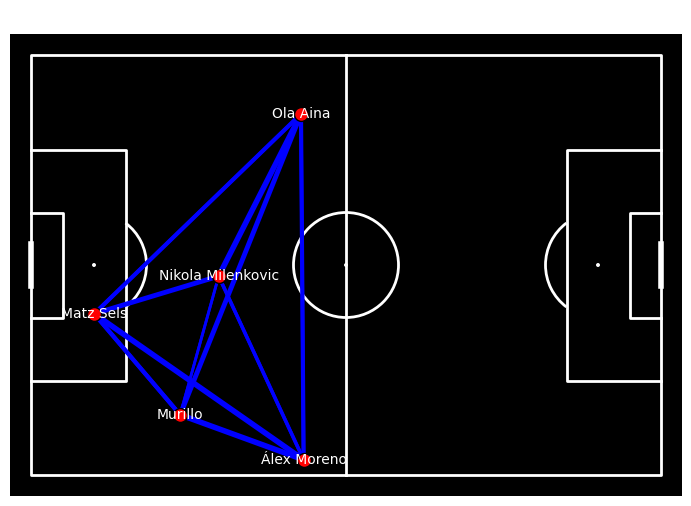

In [32]:
pass_network=create_pass_network(merged_df)

In [29]:
merged_df.columns

Index(['Unnamed: 0_x', 'id', 'eventId', 'minute', 'second', 'teamId', 'x', 'y',
       'expandedMinute', 'period', 'type', 'outcomeType', 'qualifiers',
       'satisfiedEventsTypes', 'isTouch', 'playerId', 'endX', 'endY',
       'goalMouthY', 'Unnamed: 0_y', 'shirtNo', 'name', 'pass_distance',
       'is_progressive', 'pass_recipient'],
      dtype='object')

In [30]:
merged_df['period'].unique()

array(['FirstHalf', 'SecondHalf'], dtype=object)

In [33]:
merged_df['name'].unique()

array(['Matz Sels', 'Murillo', 'Ola Aina', 'Nikola Milenkovic',
       'Álex Moreno'], dtype=object)

In [35]:
merged_df['playerId'].unique()

array([ 78386., 445424., 315543., 319785., 135374.])

In [39]:
player_df=merged_df[merged_df['name']=='Murillo']

In [40]:
player_df.head()

,Unnamed: 0_x,id,eventId,minute,second,teamId,x,y,expandedMinute,period,type,outcomeType,qualifiers,satisfiedEventsTypes,isTouch,playerId,endX,endY,goalMouthY,Unnamed: 0_y,shirtNo,name,pass_distance,is_progressive,pass_recipient
1,6,2.719864e+09,8,0,12.0,Nottingham Forest,45.2,26.1,0,FirstHalf,Pass,Successful,Length,"[91, 119, 117, 30, 139, 36, 38, 216, 218]",True,445424.0,54.7,8.4,NaN,2,5,Murillo,20.088305,True,Ola Aina
5,85,2.719877e+09,48,5,48.0,Nottingham Forest,4.4,61.2,5,FirstHalf,Pass,Successful,PassEndX,"[91, 117, 30, 35, 38, 215, 218]",True,445424.0,2.4,52.2,NaN,2,5,Murillo,9.219544,False,Matz Sels
13,171,2.719889e+09,85,10,41.0,Nottingham Forest,31.3,80.9,10,FirstHalf,Pass,Successful,PassEndX,"[91, 117, 30, 35, 38, 215, 218]",True,445424.0,27.4,53.8,NaN,2,5,Murillo,27.379189,False,Nikola Milenkovic
16,199,2.719893e+09,93,12,9.0,Nottingham Forest,40.0,95.1,12,FirstHalf,Pass,Successful,Length,"[91, 119, 117, 124, 127, 132, 205, 36, 38, 217...",True,445424.0,78.1,6.2,NaN,2,5,Murillo,96.720318,True,Ola Aina
21,215,2.719895e+09,102,13,30.0,Nottingham Forest,39.7,88.4,13,FirstHalf,Pass,Successful,PassEndX,"[91, 119, 117, 124, 127, 132, 205, 36, 38, 217...",True,445424.0,76.3,4.4,NaN,2,5,Murillo,91.627289,True,Ola Aina


**CREATE PASS MAPS**

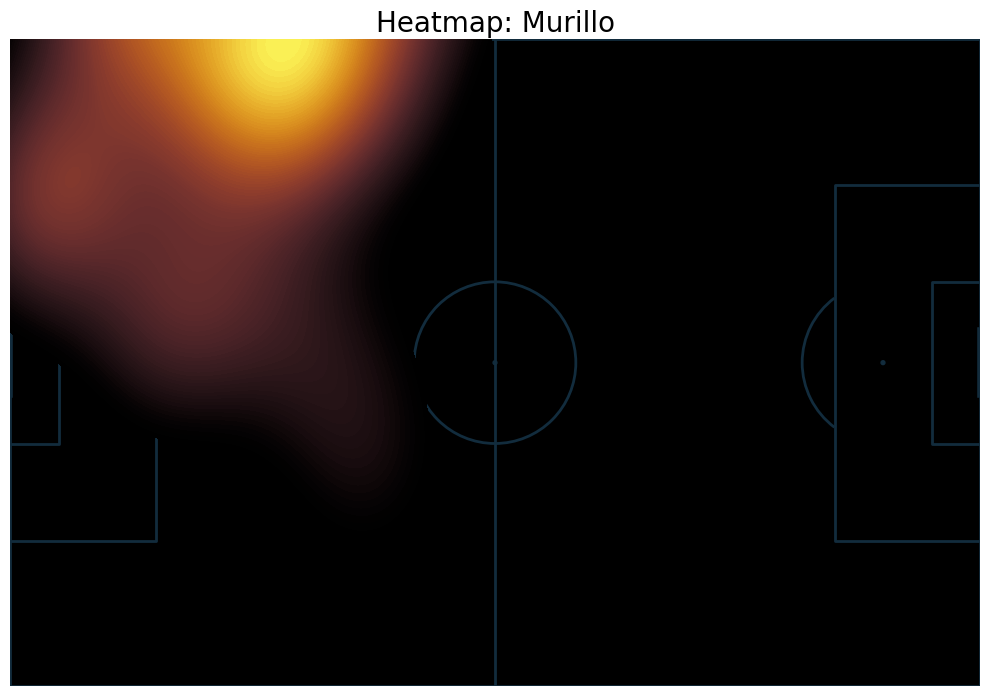

In [45]:
import cmasher as cmr

player_start_x=player_df['x']
player_start_y=player_df['y']

# Set up the pitch
pitch = Pitch(pitch_type='statsbomb', pitch_color='black', line_color='#122c3d')
fig, ax = pitch.draw(figsize=(10, 7))

# Plot KDE heatmap with cmasher color map
sns.kdeplot(
    x=player_start_x, 
    y=player_start_y, 
    cmap=cmr.amber,  # Choose a color map from cmasher
    ax=ax,
    levels=100,
    fill=True,
    thresh=0.1
    
     # Adjust to filter out low-density areas
)

# Set axis limits to match pitch dimensions
ax.set_xlim(0, 120)
ax.set_ylim(0, 80)

# Add a title
ax.set_title('Heatmap: Murillo', fontsize=20)

# Display the plot
plt.show()


In [47]:
milenkovic_df=merged_df[merged_df['name']=='Nikola Milenkovic']

In [48]:
milenkovic_df.head()

,Unnamed: 0_x,id,eventId,minute,second,teamId,x,y,expandedMinute,period,type,outcomeType,qualifiers,satisfiedEventsTypes,isTouch,playerId,endX,endY,goalMouthY,Unnamed: 0_y,shirtNo,name,pass_distance,is_progressive,pass_recipient
7,91,2.719877e+09,53,6,0.0,Nottingham Forest,39.0,19.1,6,FirstHalf,Pass,Successful,Length,"[91, 117, 30, 36, 38, 216, 218]",True,319785.0,43.9,4.9,NaN,3,31,Nikola Milenkovic,15.021651,True,Ola Aina
14,172,2.719889e+09,86,10,43.0,Nottingham Forest,26.0,51.2,10,FirstHalf,Pass,Successful,Length,"[91, 117, 30, 35, 38, 215, 218]",True,319785.0,12.8,42.9,NaN,3,31,Nikola Milenkovic,15.592626,False,Matz Sels
19,206,2.720244e+09,691,12,55.0,Nottingham Forest,51.6,7.8,12,FirstHalf,Pass,Unsuccessful,Angle,"[91, 120, 128, 36, 37, 217, 218]",True,319785.0,72.3,33.7,NaN,3,31,Nikola Milenkovic,33.155693,True,Álex Moreno
37,337,2.719914e+09,169,21,40.0,Nottingham Forest,54.7,56.1,21,FirstHalf,Pass,Successful,StandingSave,"[91, 117, 30, 35, 37, 216, 218]",True,319785.0,47.9,69.3,NaN,3,31,Nikola Milenkovic,14.848569,False,Murillo
39,348,2.719915e+09,177,22,3.0,Nottingham Forest,53.4,81.1,22,FirstHalf,Pass,Successful,Angle,"[91, 117, 127, 35, 38, 215, 218]",True,319785.0,23.6,61.8,NaN,3,31,Nikola Milenkovic,35.503943,False,Matz Sels


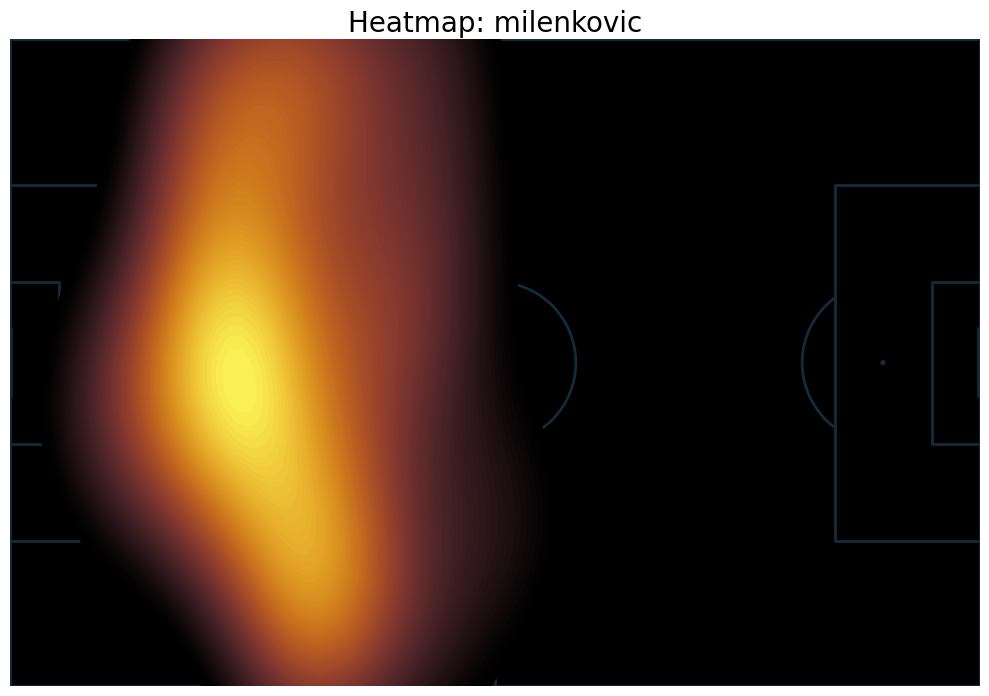

In [50]:
import cmasher as cmr

player_start_x=milenkovic_df['x']
player_start_y=milenkovic_df['y']

# Set up the pitch
pitch = Pitch(pitch_type='statsbomb', pitch_color='black', line_color='#122c3d')
fig, ax = pitch.draw(figsize=(10, 7))

# Plot KDE heatmap with cmasher color map
sns.kdeplot(
    x=player_start_x, 
    y=player_start_y, 
    cmap=cmr.amber,  # Choose a color map from cmasher
    ax=ax,
    levels=100,
    fill=True,
    thresh=0.1
    
     # Adjust to filter out low-density areas
)

# Set axis limits to match pitch dimensions
ax.set_xlim(0, 120)
ax.set_ylim(0, 80)

# Add a title
ax.set_title('Heatmap: milenkovic', fontsize=20)

# Display the plot
plt.show()
